In [189]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
import pandas as pd 
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## 1. Loading, Processing and Splitting Data

In [190]:
df = pd.read_csv(r".\NUS_IT\Train_Set.csv")
val_df = pd.read_csv(r".\NUS_IT\Test_Set.csv")
print("Dimensions of DataFrame:",df.shape)
df.head()

Dimensions of DataFrame: (2193, 351)


,length_51,length_52,length_53,length_54,length_55,length_56,length_57,length_58,length_59,length_60,...,length_392,length_393,length_394,length_395,length_396,length_397,length_398,length_399,length_400,class_label
0,0.000152,0.000082,0.000087,0.000092,0.000099,0.000125,0.000122,0.000115,0.000151,0.000167,...,0.007396,0.007193,0.006973,0.006481,0.006139,0.005958,0.005578,0.005327,0.005142,healthy
1,0.006256,0.006413,0.006512,0.006469,0.006810,0.007070,0.007748,0.008088,0.008671,0.008835,...,0.017830,0.017033,0.016373,0.015371,0.014340,0.013975,0.013243,0.012725,0.012267,healthy
2,0.003783,0.003886,0.004063,0.004237,0.004481,0.004832,0.004960,0.005605,0.005919,0.006480,...,0.010957,0.010481,0.009782,0.009211,0.008800,0.008320,0.007869,0.007286,0.007020,healthy
3,0.004635,0.004471,0.004383,0.004829,0.004920,0.005056,0.005475,0.006158,0.007174,0.007697,...,0.010032,0.008933,0.008970,0.008546,0.008125,0.007587,0.007501,0.006931,0.006663,healthy
4,0.011315,0.010045,0.009795,0.009906,0.010630,0.011467,0.013024,0.014853,0.016874,0.017501,...,0.009118,0.008535,0.008233,0.007754,0.007584,0.006933,0.006530,0.006378,0.005842,healthy


In [191]:
## Checking the number of columns with missing values 
df.columns[df.isna().sum()>0] # no columns with missing values 

Index([], dtype='object')

In [192]:
df.dtypes.value_counts() # 350 columns with float dtypes (decimal type); 1 which is non-numeric (target)

float64    350
object       1
dtype: int64

In [193]:
df['class_label'].value_counts() # imbalanced dataset; either will upsample using SMOTE / use class weights; latter approach preferable

early stage cancer        781
screening stage cancer    490
mid stage cancer          453
late stage cancer         409
healthy                    60
Name: class_label, dtype: int64

In [194]:
dic={"healthy":1,"screening stage cancer":1,"early stage cancer":2,"mid stage cancer":3,"late stage cancer":4} 
# presumption is that screening stage is before early stage --> 
# no development of cancer certain; only being checked
# will equate that with healthy stage
df['class_label'].map(dic).value_counts() # mapped appropriately

2    781
1    550
3    453
4    409
Name: class_label, dtype: int64

In [195]:
df['class_label'] = df['class_label'].map(dic)           
# changes the class_label column to numeric (ML model requires numeric data)
val_df['class_label'] = val_df['class_label'].map(dic) 
# likewise for the class_label column in the calidation dataset (val_df)

In [196]:
#### --> train test split first (from only the train data csv ; test data csv will be used for validation (unseen data))
r_state = 27 # for controlling of state 
target = "class_label" 
# for benefit of ez reference >> as opposed to always typing "class_label"
X_features=[i for i in df.columns if i!=target] 
# all independent features

test_p = 0.35

X_train,X_test,y_train,y_test= train_test_split(df[X_features],df[target],test_size=test_p,stratify=df[target],random_state = r_state)
df = pd.concat([X_train,y_train],axis=1) 
# train dataset
dft = pd.concat([X_test,y_test],axis=1) 
# test dataset

In [197]:
scaler = StandardScaler()
df[X_features] = scaler.fit_transform(df[X_features]) # train data (df) is used for fitting and transformation

Based on the train_set csv file, no data has to be imputed owing to all columns being fully filled. 
350/351 columns are also numeric; with only the taget column (class_label) being ordinal; and thus requiring Label Encoding 
performed manually using a dictionary. 

For the encoding of this column, both Healthy and Screening Stage patients are assigned 
to the same category (Healthy/Screenign Stage) owing to the lack of evidence for people in both of these categories to having 
a specific stage of cancer + the low sample size of Healthy patients alone. With all classes having a various number of samples
that isn't balanced - class_weights will be used in the training of models to overcome this problem. 
Standardisation is also employed to scale the data in such a way that it performs well on Machine Learning (ML) models like 
K-Nearest Neighbours (KNNs) and Support Vector Machines (SVMs).

## 2. Identifying Important Features and Model Comparisons

In [198]:
model = RandomForestClassifier(random_state=r_state,class_weight='balanced')
model.fit(df[X_features], df[target])
sig_features = model.feature_importances_
feature_scores = sorted([(i,e) for i,e in enumerate(sig_features)],key=lambda x:x[-1],reverse=True)
forest_features = df.columns[list(map(lambda x:x[0],feature_scores))]

In [199]:
# Also will take a while as model is being trained
def model_trainer(df,dft,best_cols):
    dt_clf  = DecisionTreeClassifier(random_state=r_state,class_weight='balanced')
    dt_clf.fit(df[best_cols],df[target])

    rf_clf  = RandomForestClassifier(random_state=r_state,class_weight='balanced')
    rf_clf.fit(df[best_cols],df[target])

    xgb_clf = GradientBoostingClassifier(random_state=r_state)
    xgb_clf.fit(df[best_cols],df[target])

    svm_clf = SVC(random_state=r_state,gamma='scale')
    svm_clf.fit(df[best_cols],df[target])
    
    sqrt_n = ((df.shape[0])**0.5)//1
    sqrt_n = int(sqrt_n + (1 if sqrt_n%2==0 else 0))
    knn_clf = KNeighborsClassifier(n_neighbors = sqrt_n)
    knn_clf.fit(df[best_cols],df[target])

    dt_pred  = dt_clf.predict(dft[best_cols])
    rf_pred  = rf_clf.predict(dft[best_cols])
    xgb_pred = xgb_clf.predict(dft[best_cols])
    svm_pred = svm_clf.predict(dft[best_cols])
    knn_pred = knn_clf.predict(dft[best_cols])

    reverse_lis = [k for k,v in sorted(dic.items(),key=lambda x:x[-1])]
    reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:]
    
    print("Decision Tree Report:")
    dt_r = classification_report(dft[target],dt_pred,target_names = reverse_lis)
    print(dt_r)
    print("Random Forest Report:")
    rf_r = classification_report(dft[target],rf_pred,target_names = reverse_lis)
    print(rf_r)
    print("XGBoost Report:")
    xg_r = classification_report(dft[target],xgb_pred,target_names = reverse_lis)
    print(xg_r)
    print("SVM Report:")
    sv_r = classification_report(dft[target],svm_pred,target_names = reverse_lis)
    print(sv_r)
    print("KNN Report:")
    kn_r = classification_report(dft[target],knn_pred,target_names = reverse_lis)
    print(kn_r)
    return [dt_r,rf_r,xg_r,sv_r,kn_r]

5 different ML models are utilised - Decision Trees, Random Forest, Extreme Gradient Boosting, KNN and SVM
The metrics from sklearn's classification reports are used as a standard to compare the performances of the models, 
notably with the f1 score. 

Models with significantly poorer f1 score results will be removed further on and hyperparameter
tuning will be performed on the best-performing model from the 5 selected above.

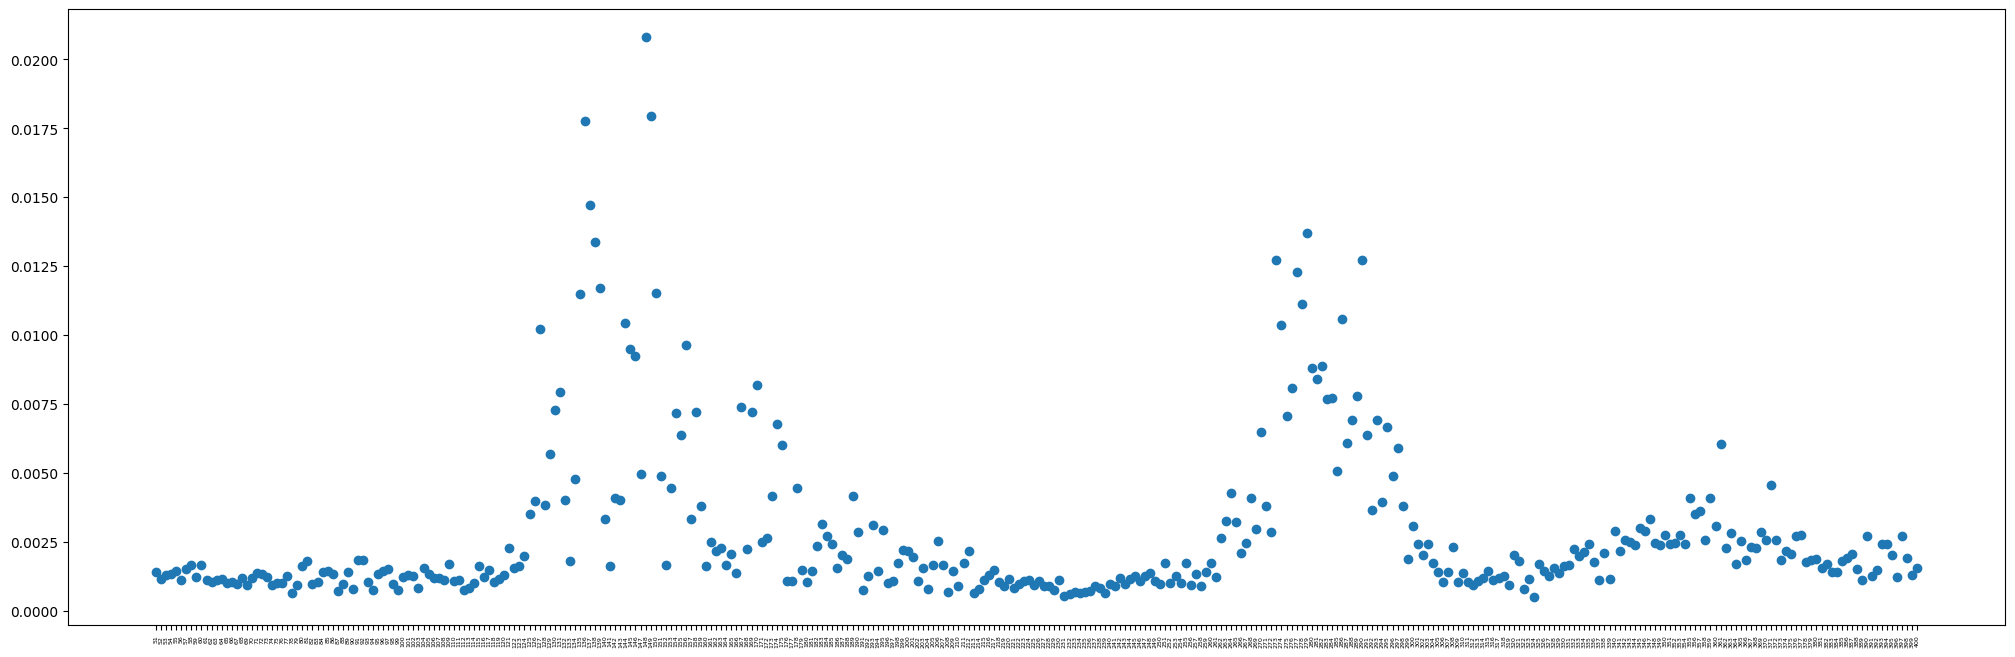

In [200]:
scores_by_cols = sorted(list(zip(forest_features,map(lambda x:x[-1],feature_scores))),key=lambda x:int(x[0].split('_')[-1]))
colnames = list(map(lambda x:x[0].split('_')[-1],scores_by_cols))
scores = list(map(lambda x:x[1],scores_by_cols))
plt.figure(figsize=(25,8))
plt.scatter(colnames,scores)
plt.xticks(rotation=90)
plt.tick_params(axis='x',labelsize=4.5)
plt.show()

In the meanwhile, the feature scores of the different independent columns are observed - with the aim being to identify a benchmark
at which a number of features can be chosen to grant good performance for the final ML model without requiring too many features to be selected - avoiding the [curse of dimensionality](https://dataloop.ai/blog/the-curse-of-dimensionality-dimension-reduction/#:~:text=The%20curse%20of%20dimensionality%20refers,features%20that%20exist%20in%20it).

In [201]:
scores = np.array(scores)
print(f"Median Score: {np.median(scores)}")
print(f"Mean Score  : {np.mean(scores)}")
iqr = np.quantile(scores,(0.25,0.75))
print(f"Scores at 25th percentile: {iqr[0]:.6f} and\n\t  75th percentile: {iqr[-1]:.6f}")

Median Score: 0.0016886480692305493
Mean Score  : 0.0028571428571428576
Scores at 25th percentile: 0.001143 and
	  75th percentile: 0.002875


In [202]:
above_75th = len(scores[scores>=iqr[1]])
above_mean = len(scores[scores>=np.mean(scores)])
above_median = len(scores[scores>=np.median(scores)])
above_25th = len(scores[scores>=iqr[0]])
above_p = [('25th percentile',above_25th),('median',above_median),('mean',above_mean),('75th percentile',above_75th)]
print("Number of Features with scores\n" +'\n'.join([f'above the {i[0]:<16}: '+str(i[-1]) for i in above_p]))
# aim to look at number of top n-ranked features where n is 
# a number from 90 - 275 >> basis of comparison against all features (350)

Number of Features with scores
above the 25th percentile : 262
above the median          : 175
above the mean            : 90
above the 75th percentile : 88


Given how there are 88 features with a score above the 75th percentile of the scores of all features and 262 features with a score above the 25th percentile, we aim to observe the performance of our ML models based on set changes in the number of features used in our dataset and compare the average f1 score for accuracy, macro avg and weighted avg amongst all the models

In [203]:
dft[X_features] = scaler.transform(dft[X_features]) 
# test set of data is scaled based off standardized range of train data

In [204]:
# code cell runs for abt 9 - 15 min 
d={}
no_of_features = [90,100,125,150,175,225,275,350]
for i in no_of_features: 
    print(f"Top {i} features")
    best_cols = forest_features[:i]
    l = model_trainer(df,dft,best_cols) 
    a = list(map(lambda x:x.strip().split('\n'),l))
    k = ['Decision Tree','Random Forest','XGBoost','SVM','KNN']
    for n,e in enumerate(a):
        key = f"{i} - {(k[n])}"
        z=[float(i[-1]) for i in list(map(lambda x:re.findall("\d\.\d\d",x),e)) if len(i)>0]
        d[key] = z
# Already apparent out of the gate that Decision Tree, Random Forest 
# and XGBoost Models perform significantly better than SVM & KNN models

Top 90 features


Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.81      0.84      0.83       193
            early stage cancer       0.81      0.78      0.79       273
              mid stage cancer       0.73      0.78      0.76       159
             late stage cancer       0.92      0.87      0.90       143

                      accuracy                           0.81       768
                     macro avg       0.82      0.82      0.82       768
                  weighted avg       0.81      0.81      0.81       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.90      0.89       193
            early stage cancer       0.85      0.86      0.86       273
              mid stage cancer       0.79      0.80      0.80       159
             late stage cancer       0.94      0.85      0.89       143

               

In [205]:
features = sorted(set(map(lambda x:int(x.split('-')[0].strip()),d.keys())))
models = list(map(lambda x:(x.split('-')[-1].strip()),d.keys()))[:5]
data=[]
for e in features:
    li=[e]
    for m in models:
        li.append(sum(d[f"{e} - {m}"][:4])/4) 
    data.append(li) 
# average f1 score (last 3 f1 metrics) of different ML models with different 
# number of features is calculated and displayed in bar graph below

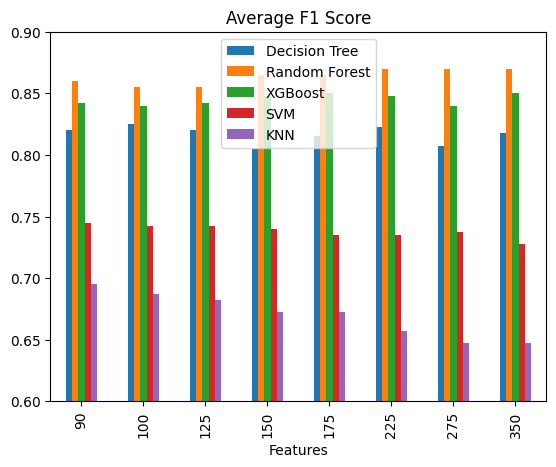

In [206]:
tf = pd.DataFrame(data, columns=['Features']+models)
tf.plot(x='Features', 
        kind='bar', 
        stacked=False, 
        title='Average F1 Score')
plt.ylim(bottom=0.6,top=0.9)
plt.show() # significantly apparent that Decision Tree, Random Forest 
# and XGBoost (Extreme Gradient Boost) classifiers perform better han SVM and KNN 
# >> will remove the latter 2 instances and focus on the former 3

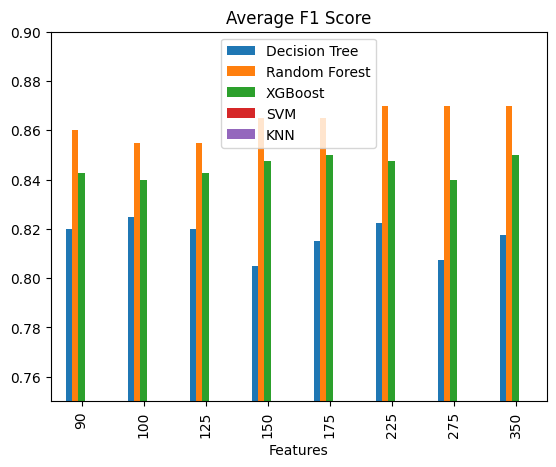

In [207]:
tf.plot(x='Features', 
        kind='bar', 
        stacked=False, 
        title='Average F1 Score')
plt.ylim(bottom=0.75,top=0.9)
plt.show()
# clear that amongst all the models, Random Forest (RF) performs the best; 
# also apparent that at 225 features, average f1 score for RF begins to plateau 
# with still relatively greater than average results for f1 scores for XGBoost and
# Decision Tree Models at top 225 features >> good balance between performance and number of features 

In [208]:
best_cols = forest_features[:225] # looking at the top 225 best ranked features
# owing to earliest peak in average f1 score for Random Forest; alongside optimal performance 
# in XGBoost results for the f1 score as well

## 3. Hyperparameter Tuning and Model Evaluation

In [209]:
reverse_lis = [k for k,_ in sorted(dic.items(),key=lambda x:x[-1])]
reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:]

In [60]:
# as from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 75, 100, 150, None],
 'max_leaf_nodes':[2,3,5,10,None],
 'min_samples_split': [2,3,5],
 'criterion':['gini','entropy'],
 'n_estimators': [50, 75, 100, 200, 500]}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=r_state,class_weight='balanced'), param_distributions= params, 
                               n_iter=10,cv = StratifiedKFold(n_splits=5,random_state=r_state,shuffle=True))
# random search CV used to narrow down to certain parameters

For the first run of hyperparamter tuning, 5 iterations of RandomizedSearchCV are implemented owing to the large number of parameters used - hence, to have a relatively quick run of the different paramteres while being able to compare and contrast most of them in terms of their similarities in a majority class (e.g. how most runs give `criterion = entropy`/ `max_leaf_nodes = None`), some of the parameters can be fixed/ have a narrowed down range to be evaluated completely using GridSearchCV. It is important to note however that not every run of RandomizedSearchCV is guaranteed to give the output commented in the lines below; but the resulting parameters are likely to be better than the default ones - especially once they are passed into GridSearchCV.

In [61]:
# takes 20 min to half an hour to run this code cell >> code is placed in multi-line string 
"""
for e in range(5): # run 5 times to observe similarities and differences in outputs of random CV 5 times
    rf_random.fit(df[best_cols],df[target]) 
    print(rf_random.best_params_) 
"""
# may remove the string quotes to run the code; do take note on the time required

### Observed Output ###
# {'n_estimators': 75, 'min_samples_split': 5, 'max_leaf_nodes': None, 'max_depth': 150, 'criterion': 'entropy', 'bootstrap': False}
# {'n_estimators': 100, 'min_samples_split': 3, 'max_leaf_nodes': None, 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
# {'n_estimators': 500, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': 75, 'criterion': 'entropy', 'bootstrap': True}
# {'n_estimators': 100, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': 150, 'criterion': 'entropy', 'bootstrap': False}
# {'n_estimators': 500, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}

{'n_estimators': 75, 'min_samples_split': 5, 'max_leaf_nodes': None, 'max_depth': 150, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 100, 'min_samples_split': 3, 'max_leaf_nodes': None, 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 500, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': 75, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 100, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': 150, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 500, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}


In [64]:
refined_params = {'bootstrap': [True,False],
 'max_depth': [75, 100, 150, None],
 'max_leaf_nodes':[None],
 'min_samples_split': [2,3,5],
 'criterion':['entropy'],
 'n_estimators': [100, 200, 500]}
rf_grid = GridSearchCV(estimator = RandomForestClassifier(random_state=r_state,class_weight='balanced'), param_grid= refined_params, 
                        cv = StratifiedKFold(n_splits=5,random_state=r_state,shuffle=True))
# Grid Search CV is used to evaluate ALL narrowed down parameters to give optimised result

With RandomizedSearchCV helping to hone in on the parameters to be optimised, Cross Validation (CV) is carries out again, this time using GridSearchCV, to guarantee the optimal paramters are obtained. However, owing to the long time GridSearchCV takes as it copares all permutations of paramters, it was **NOT** used at the start in order to save time on running the code file

In [65]:
# takes about 1 - 1.5 hours to run this code cell >> code is placed in multi-line string 
"""
rf_grid.fit(df[best_cols],df[target]) 
print(rf_grid.best_params_)
"""
# may remove the string quotes to run the code; do take note on the time required

### Observed Output ###
# {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 75, 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 100}

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 75, 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 100}


In [210]:
rf_h = RandomForestClassifier(random_state=r_state,max_depth = 75,max_leaf_nodes = None,min_samples_split = 2,
    n_estimators = 100,class_weight='balanced',criterion='entropy',bootstrap=False)
rf_h.fit(df[best_cols],df[target]) 
y_pred = rf_h.predict(dft[best_cols])
print(classification_report(dft[target],y_pred,target_names = reverse_lis)) 
# hyperparameter model performs marginally better to original model >> better f1 performance

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.93      0.90       193
            early stage cancer       0.89      0.89      0.89       273
              mid stage cancer       0.83      0.82      0.83       159
             late stage cancer       0.93      0.87      0.90       143

                      accuracy                           0.88       768
                     macro avg       0.88      0.88      0.88       768
                  weighted avg       0.88      0.88      0.88       768



In [211]:
val_df[X_features] = scaler.transform(val_df[X_features])

In [212]:
model_clf = RandomForestClassifier(random_state=r_state,class_weight='balanced') 
# initial model with no change to parameters
model_clf.fit(df[best_cols],df[target])
model_pred = model_clf.predict(val_df[best_cols]) 
print(classification_report(val_df[target],model_pred,target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.74      0.53      0.62       271
            early stage cancer       0.62      0.72      0.67       368
              mid stage cancer       0.61      0.72      0.66       206
             late stage cancer       0.88      0.78      0.82       189

                      accuracy                           0.68      1034
                     macro avg       0.71      0.69      0.69      1034
                  weighted avg       0.70      0.68      0.68      1034



In [213]:
print(classification_report(val_df[target],rf_h.predict(val_df[best_cols]),target_names = reverse_lis))
# hyperparametised model performs BETTER on test set 
# than base/default model with no change to parameters

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.77      0.59      0.67       271
            early stage cancer       0.66      0.74      0.69       368
              mid stage cancer       0.62      0.75      0.68       206
             late stage cancer       0.89      0.77      0.83       189

                      accuracy                           0.71      1034
                     macro avg       0.74      0.71      0.72      1034
                  weighted avg       0.72      0.71      0.71      1034



In [214]:
dff = pd.concat([df,dft]) # using ENTIRE training dataset (whole of train_set.csv)

In [215]:
dff[X_features] = scaler.fit_transform(dff[X_features])
val_df[X_features] = scaler.transform(val_df[X_features])

In [216]:
rf_clf = RandomForestClassifier(random_state=r_state,max_depth = 75,max_leaf_nodes = None,min_samples_split = 2,
    n_estimators = 100,class_weight='balanced',criterion='entropy',bootstrap=False)
rf_clf.fit(dff[best_cols],dff[target])
p = rf_clf.predict(val_df[best_cols])
print(classification_report(val_df[target],p,target_names = reverse_lis))
# using full train dataset gives lower performance for f1-score across different categories compared 

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.76      0.58      0.66       271
            early stage cancer       0.64      0.70      0.67       368
              mid stage cancer       0.59      0.70      0.64       206
             late stage cancer       0.83      0.79      0.81       189

                      accuracy                           0.69      1034
                     macro avg       0.71      0.69      0.69      1034
                  weighted avg       0.70      0.69      0.69      1034



In [226]:
# final model >> standardised scaling and hyperparameterised model fit on PARTIAL train dataset (65% split of train_data.csv)
df = pd.read_csv(r".\NUS_IT\Train_Set.csv")
df[target] = df[target].map(dic)
X_train,X_test,y_train,y_test= train_test_split(df[X_features],df[target],test_size=test_p,stratify=df[target],random_state = r_state)
df = pd.concat([X_train,y_train],axis=1) 
# pipeline of the model is made >> including both the step on scaling the data and parsing it through the model
scaler = StandardScaler()
final_model = rf_h
pipe = Pipeline([('scaler', scaler), ('model', final_model)])
pipe.fit(df[X_features],df[target])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=75,
                                        random_state=27))])

## 4. Saving the final model

In [227]:
with open('CancerStagersModel.pkl','wb') as f:
    pickle.dump(pipe,f) 